# PyTorch MNIST example

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

c:\Users\kris\anaconda3\envs\uitnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from utils import generate_phoc_vector, generate_phos_vector
import pandas as pd
import numpy as np

location_image = "./dte2502_ga01_small\valid"
location_csv = "./dte2502_ga01_small/valid.csv"

df_all = pd.read_csv(location_csv)

df_all['phoc'] = df_all['Word'].apply(generate_phoc_vector)
df_all['phos'] = df_all['Word'].apply(generate_phos_vector)

# Places the arrays after eachother.
df_all['phosc'] = df_all.apply(lambda row: np.concatenate((row['phoc'], row['phos'])), axis=1)


print(torch.cuda.is_available())
print(torch.__version__)



False
1.13.1


In [8]:
print(f"train_data: {train_data},\n test_data: {test_data}")

train_data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor(),
 test_data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
print(train_data[1])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

## Visualize the data

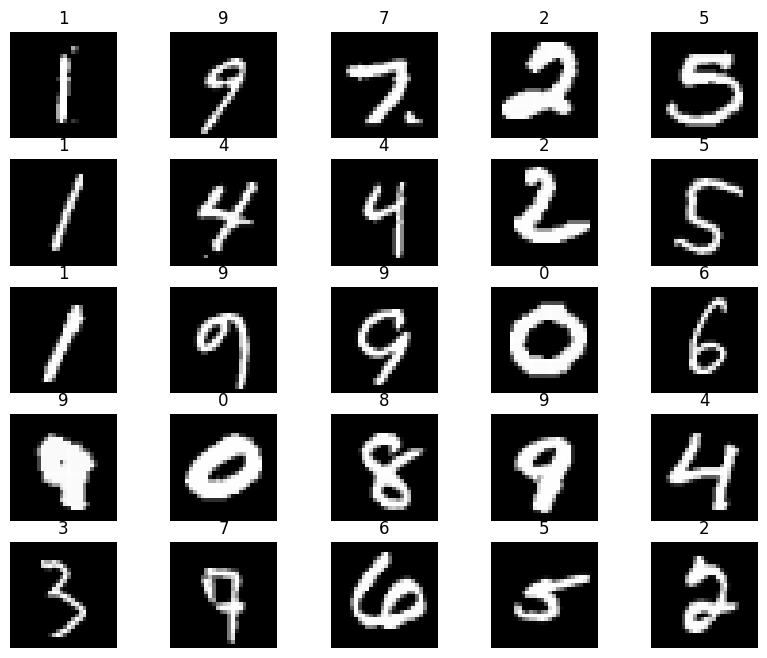

In [10]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Building `DataLoaders` classes to load data

In [11]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)
loaders = {
    'train' : train_loader,
    'test': test_loader,
}

In [12]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x00000213323DA9D0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000002133498E3D0>}


## Using the `dataloader`

torch.Size([100, 1, 28, 28])


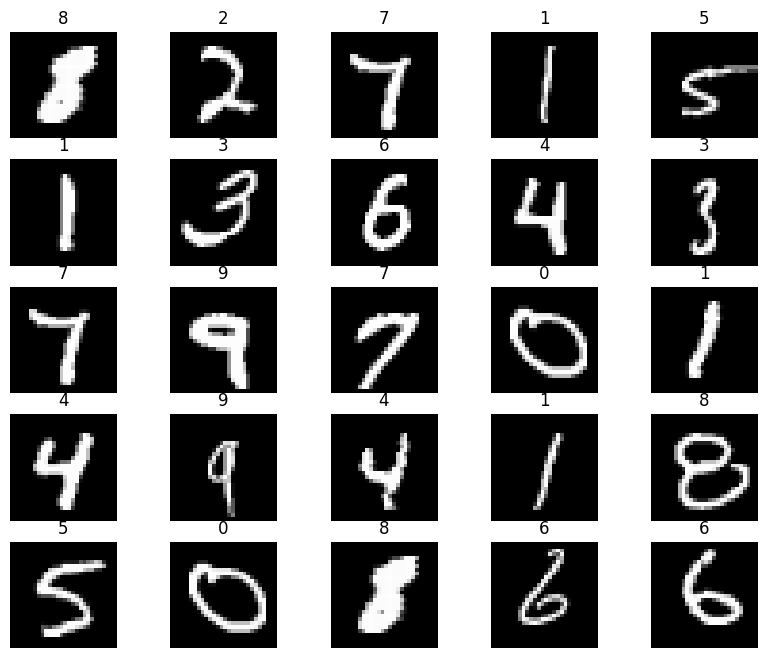

In [13]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

imgs, labels = next(iter(loaders['train']))
print(imgs.shape)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx,:,:,:], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [14]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [15]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function

In [16]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Optimizer

In [17]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Train the model

In [18]:
num_epochs = 10

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            output = cnn(images)
            loss = loss_func(output, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward() # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            

In [19]:
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.2822
Epoch [1/10], Step [200/600], Loss: 0.0310
Epoch [1/10], Step [300/600], Loss: 0.1099
Epoch [1/10], Step [400/600], Loss: 0.0116
Epoch [1/10], Step [500/600], Loss: 0.1332
Epoch [1/10], Step [600/600], Loss: 0.0144
Epoch [2/10], Step [100/600], Loss: 0.0354
Epoch [2/10], Step [200/600], Loss: 0.0925
Epoch [2/10], Step [300/600], Loss: 0.0508
Epoch [2/10], Step [400/600], Loss: 0.0360
Epoch [2/10], Step [500/600], Loss: 0.0051
Epoch [2/10], Step [600/600], Loss: 0.0526
Epoch [3/10], Step [100/600], Loss: 0.0723
Epoch [3/10], Step [200/600], Loss: 0.1058
Epoch [3/10], Step [300/600], Loss: 0.0557
Epoch [3/10], Step [400/600], Loss: 0.0181
Epoch [3/10], Step [500/600], Loss: 0.0426
Epoch [3/10], Step [600/600], Loss: 0.0417
Epoch [4/10], Step [100/600], Loss: 0.0028
Epoch [4/10], Step [200/600], Loss: 0.0139
Epoch [4/10], Step [300/600], Loss: 0.0069
Epoch [4/10], Step [400/600], Loss: 0.0069
Epoch [4/10], Step [500/600], Loss: 0.0101
Epoch [4/10

## Test the model on test dataset

In [23]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [24]:
test()

Test Accuracy of the model on the 10000 test images: 0.99


## Print predictions

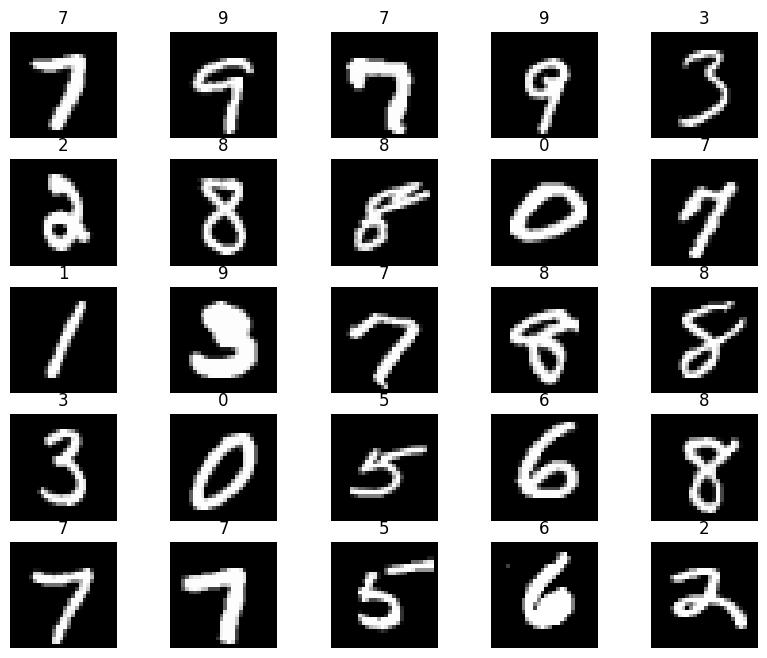

Prediction number: 	 [7 9 7 9 3 2 8 8 0 7 1 9 7 8 8 3 0 5 6 8 7 7 5 6 2]
Actual number: 	 	 [7 9 7 9 3 2 8 8 0 7 1 3 7 8 8 3 0 5 6 8 7 7 5 6 2]


In [25]:
imgs, lbls  = next(iter(loaders['test']))
true_labels = lbls[:25].numpy()

test_output = cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f'Prediction number: \t {pred_labels}')
print(f'Actual number: \t \t {true_labels}')